In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import pathlib  # pathlib is in standard library
import pandas as pd

batch_size = 32
img_height = 224
img_width = 224

directory = "../input/crowd-counting/frames/frames/"
counts_df = pd.read_csv('../input/crowd-counting/labels.csv')  
file_path_ds = tf.data.Dataset.list_files(str(pathlib.Path(directory + "*.jpg")), seed=0)

In [2]:
count_l = []
file_path_l = []
for file_path in file_path_ds.as_numpy_iterator():
    id_count = int(str(file_path).split('/')[-1].split('.')[0].split('_')[-1])
    count = counts_df[counts_df['id']==id_count]['count'].values.astype(float)[0]
    count_l.append(count)
    file_path_l.append(file_path)

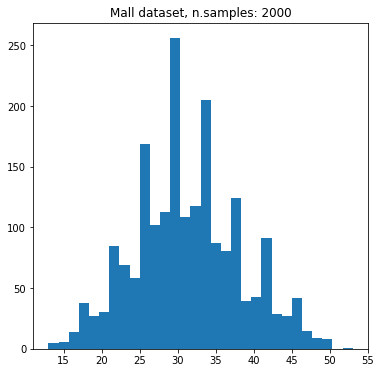

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
hist_fig = plt.figure(figsize=(6,6))
_ = plt.hist(count_l,bins=30)
_ = plt.title('Mall dataset, n.samples: '+str(len(file_path_l)))
plt.show()
_ = hist_fig.savefig('mall dataset hist.png')

In [4]:
def process_path(file_path, count):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    return image, count

full_ds = tf.data.Dataset.from_tensor_slices((file_path_l, count_l))
full_ds = full_ds.map(process_path)

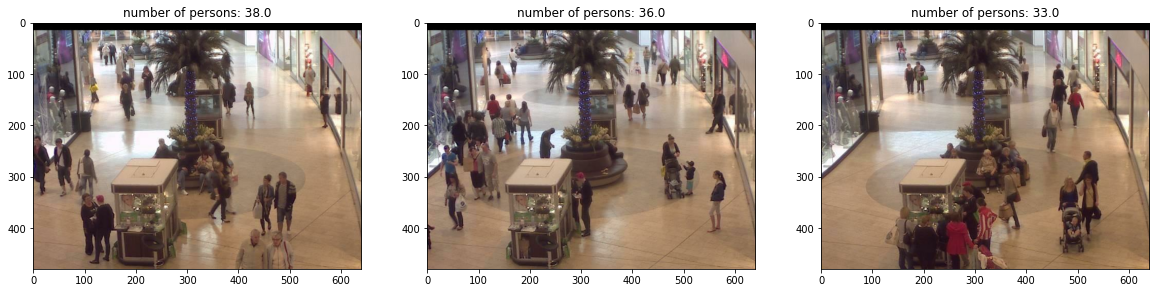

In [5]:
fig = plt.figure(figsize=(20,10))
for i, sample in enumerate(full_ds.take(3).as_numpy_iterator()):
    image = sample[0]
    _ = plt.subplot(1,3,i+1)
    _ = plt.imshow(image)
    _ = plt.title('number of persons: '+ str(sample[1]))
plt.show()

In [6]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places.
    @param dataset: the input dataset to split.
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1.
    @return: a tuple of two tf.data.Datasets as (training, validation)
    """

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(height=img_height, width=img_width)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)
flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')

train_ds, val_ds = split_dataset(full_ds, 0.2)

length_train = [i for i,_ in enumerate(train_ds)][-1] + 1
length_val = [i for i,_ in enumerate(val_ds)][-1] + 1 #the datasets are quite small, so we can count them in this way

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda image,count: (normalization_layer((resize_layer(image))), count)).cache('./mall_training')
train_ds = train_ds.shuffle(buffer_size=100).batch(batch_size).map(lambda image,count: (flip_layer(image),count),
                                                                    num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda image,count: (normalization_layer((resize_layer(image))), count)).cache('./mall_val').batch(batch_size)
full_ds = full_ds.map(lambda image,count: (normalization_layer((resize_layer(image))), count)).cache('./mall_full').batch(batch_size)

In [7]:
print(f'n. samples in the  training set: {length_train}')
print(f'n. samples in the  validation set: {length_val}')

n. samples in the  training set: 1580
n. samples in the  validation set: 420


In [8]:
import sys
sys.path.append("../input/tempppp/")
from DenseNet import CrowdCountingFPN
fpn_121 = CrowdCountingFPN(version='121').get_model()
fpn_121.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [9]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_FPN_121.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-5, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
fpn_121.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_fpn_121 = fpn_121.fit(train_ds, validation_data=val_ds,
                    epochs=100, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/100
50/50 - 34s - loss: 69.8941 - mae: 5.2171 - val_loss: 823.4158 - val_mae: 27.8084

Epoch 00001: mae improved from inf to 5.21707, saving model to ./best_FPN_121.h5
Epoch 2/100
50/50 - 10s - loss: 14.1177 - mae: 3.0116 - val_loss: 817.0098 - val_mae: 28.0049

Epoch 00002: mae improved from 5.21707 to 3.01156, saving model to ./best_FPN_121.h5
Epoch 3/100
50/50 - 10s - loss: 11.2839 - mae: 2.6322 - val_loss: 497.1240 - val_mae: 21.9026

Epoch 00003: mae improved from 3.01156 to 2.63222, saving model to ./best_FPN_121.h5
Epoch 4/100
50/50 - 10s - loss: 6.6263 - mae: 2.0478 - val_loss: 168.5856 - val_mae: 12.6365

Epoch 00004: mae improved from 2.63222 to 2.04779, saving model to ./best_FPN_121.h5
Epoch 5/100
50/50 - 10s - loss: 6.4021 - mae: 2.0070 - val_loss: 98.1605 - val_mae: 9.5986

Epoch 00005: mae improved from 2.04779 to 2.00705, saving model to ./best_FPN_121.h5
Epoch 6/100
50/50 - 10s - loss: 5.4344 - mae: 1.8265 - val_loss: 14.4182 - val_mae: 3.2794

Epoch 00006: mae

In [10]:
fpn_121.load_weights('./best_FPN_121.h5')
fpn_121.evaluate(full_ds)

63/63 [==============================] - 13s 211ms/step - loss: 0.8147 - mae: 0.5755


[0.8147386908531189, 0.5754940509796143]

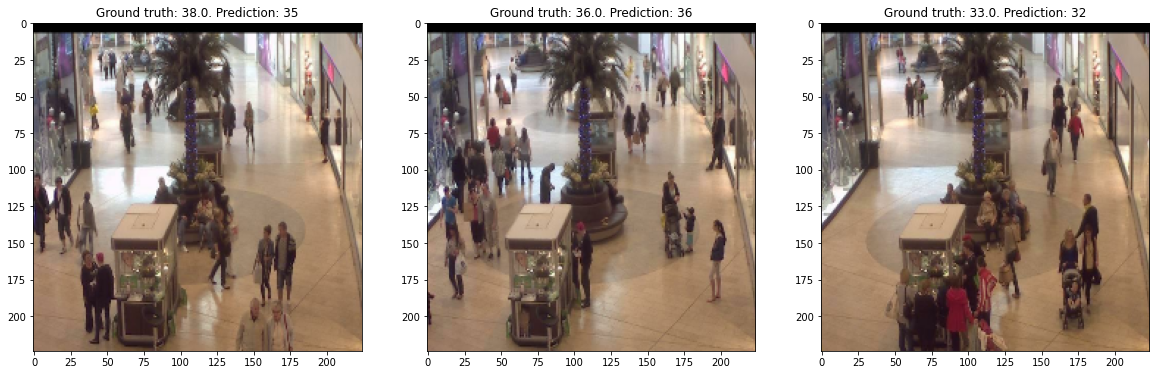

In [11]:
fig_pred = plt.figure(figsize=(20,10))

list_samples = list(full_ds.take(1).as_numpy_iterator())[0]
images = list_samples[0][:3]
labels = list_samples[1][:3]

labels_pred = fpn_121.predict(images).squeeze()

for i, image in enumerate(images):
    _ = plt.subplot(1,3,i+1)
    _ = plt.imshow(image)
    _ = plt.title('Ground truth: '+ str(labels[i])+'. Prediction: '+str(int(labels_pred[i])))
plt.show()
fig_pred.savefig('mall fpn_121 prediction.png')

In [12]:
from DenseNet import DenseNet121
model_121 = DenseNet121( input_shape = (img_height,img_width,3),
                                            include_top=False,
                                            pooling='avg',
                                          weights='imagenet'
                                         )
output = tf.keras.layers.Dense(1,
                               activation='relu', kernel_regularizer='l2')(model_121.output)
model_121 = tf.keras.Model(inputs=model_121.input, outputs=output)

In [13]:
model_121.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [14]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_DenseNet121.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-5, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model_121.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_121 = model_121.fit(train_ds, validation_data=val_ds,
                    epochs=100, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/100
50/50 - 21s - loss: 75.9172 - mae: 5.7809 - val_loss: 303042378325819392.0000 - val_mae: 549625088.0000

Epoch 00001: mae improved from inf to 5.78087, saving model to ./best_DenseNet121.h5
Epoch 2/100
50/50 - 10s - loss: 14.1025 - mae: 2.9945 - val_loss: 57291.0430 - val_mae: 237.2334

Epoch 00002: mae improved from 5.78087 to 2.99454, saving model to ./best_DenseNet121.h5
Epoch 3/100
50/50 - 10s - loss: 12.7517 - mae: 2.8036 - val_loss: 5392.5117 - val_mae: 72.3447

Epoch 00003: mae improved from 2.99454 to 2.80361, saving model to ./best_DenseNet121.h5
Epoch 4/100
50/50 - 10s - loss: 8.9979 - mae: 2.3375 - val_loss: 427.6291 - val_mae: 20.0800

Epoch 00004: mae improved from 2.80361 to 2.33750, saving model to ./best_DenseNet121.h5
Epoch 5/100
50/50 - 10s - loss: 8.8153 - mae: 2.3287 - val_loss: 50.0223 - val_mae: 6.2297

Epoch 00005: mae improved from 2.33750 to 2.32874, saving model to ./best_DenseNet121.h5
Epoch 6/100
50/50 - 10s - loss: 8.9052 - mae: 2.3758 - val_los

In [15]:
model_121.load_weights('./best_DenseNet121.h5')
model_121.evaluate(full_ds)

63/63 [==============================] - 4s 65ms/step - loss: 1.3152 - mae: 0.8053


[1.3151582479476929, 0.8052579760551453]

In [16]:
fpn_169 = CrowdCountingFPN(80,version='169').get_model()
fpn_169.summary()

51879936/51877672 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________

In [17]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_FPN_169.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-5, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
fpn_169.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_fpn_169 = fpn_169.fit(train_ds, validation_data=val_ds,
                    epochs=100, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/100
50/50 - 31s - loss: 223.7217 - mae: 9.0790 - val_loss: 1023.5435 - val_mae: 31.1833

Epoch 00001: mae improved from inf to 9.07903, saving model to ./best_FPN_169.h5
Epoch 2/100
50/50 - 13s - loss: 10.3366 - mae: 2.5192 - val_loss: 351.1907 - val_mae: 17.8943

Epoch 00002: mae improved from 9.07903 to 2.51923, saving model to ./best_FPN_169.h5
Epoch 3/100
50/50 - 13s - loss: 7.5808 - mae: 2.1968 - val_loss: 244.5424 - val_mae: 15.2640

Epoch 00003: mae improved from 2.51923 to 2.19683, saving model to ./best_FPN_169.h5
Epoch 4/100
50/50 - 13s - loss: 9.9217 - mae: 2.4657 - val_loss: 315.9667 - val_mae: 17.3682

Epoch 00004: mae did not improve from 2.19683
Epoch 5/100
50/50 - 13s - loss: 7.4130 - mae: 2.1463 - val_loss: 142.9805 - val_mae: 11.4788

Epoch 00005: mae improved from 2.19683 to 2.14627, saving model to ./best_FPN_169.h5
Epoch 6/100
50/50 - 13s - loss: 10.3830 - mae: 2.6726 - val_loss: 53.8277 - val_mae: 6.9348

Epoch 00006: mae did not improve from 2.14627
Epoch

In [18]:
fpn_169.load_weights('./best_FPN_169.h5')
fpn_169.evaluate(full_ds)

63/63 [==============================] - 5s 84ms/step - loss: 0.7204 - mae: 0.4553


[0.7204491496086121, 0.4552794396877289]

### DenseNet169

In [19]:
from DenseNet import DenseNet169
model_169 = DenseNet169( input_shape = (img_height,img_width,3),
                                            include_top=False,
                                            pooling='avg',
                                          weights='imagenet'
                                         )
output = tf.keras.layers.Dense(1,
                               activation='relu', kernel_regularizer='l2')(model_169.output)
model_169 = tf.keras.Model(inputs=model_169.input, outputs=output)

In [20]:
model_169.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [21]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_DenseNet169.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-5, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model_169.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_169 = model_169.fit(train_ds, validation_data=val_ds,
                    epochs=100, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/100
50/50 - 28s - loss: 77.6599 - mae: 6.0179 - val_loss: 12178458787746557160717455196160.0000 - val_mae: 3487900259844096.0000

Epoch 00001: mae improved from inf to 6.01786, saving model to ./best_DenseNet169.h5
Epoch 2/100
50/50 - 12s - loss: 16.6103 - mae: 3.2661 - val_loss: 39176493858816.0000 - val_mae: 6140323.5000

Epoch 00002: mae improved from 6.01786 to 3.26609, saving model to ./best_DenseNet169.h5
Epoch 3/100
50/50 - 12s - loss: 15.3381 - mae: 3.1208 - val_loss: 6810880512.0000 - val_mae: 82416.2031

Epoch 00003: mae improved from 3.26609 to 3.12076, saving model to ./best_DenseNet169.h5
Epoch 4/100
50/50 - 12s - loss: 13.0899 - mae: 2.8613 - val_loss: 282939744.0000 - val_mae: 16801.8027

Epoch 00004: mae improved from 3.12076 to 2.86134, saving model to ./best_DenseNet169.h5
Epoch 5/100
50/50 - 12s - loss: 12.4442 - mae: 2.7975 - val_loss: 62030768.0000 - val_mae: 7864.1089

Epoch 00005: mae improved from 2.86134 to 2.79750, saving model to ./best_DenseNet169.h5

In [22]:
model_169.load_weights('./best_DenseNet169.h5')
model_169.evaluate(full_ds)

63/63 [==============================] - 5s 80ms/step - loss: 7.3311 - mae: 0.8148


[7.331143856048584, 0.8148329854011536]

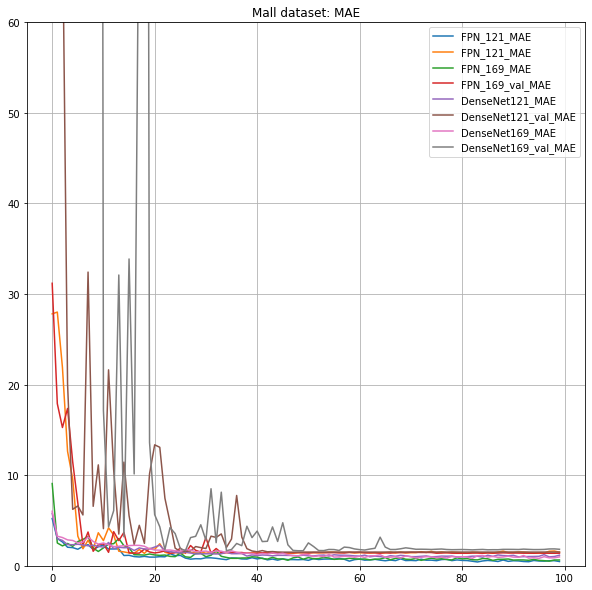

In [23]:
fig_train = plt.figure(figsize=(10,10))
plt.plot(hist_fpn_121.history['mae'], label='FPN_121_MAE')
plt.plot(hist_fpn_121.history['val_mae'], label='FPN_121_MAE')
plt.plot(hist_fpn_169.history['mae'], label='FPN_169_MAE')
plt.plot(hist_fpn_169.history['val_mae'], label='FPN_169_val_MAE')
plt.plot(hist_121.history['mae'], label='DenseNet121_MAE')
plt.plot(hist_121.history['val_mae'], label='DenseNet121_val_MAE')
plt.plot(hist_169.history['mae'], label='DenseNet169_MAE')
plt.plot(hist_169.history['val_mae'], label='DenseNet169_val_MAE')
plt.ylim(0,60)
plt.legend()
plt.grid()
plt.title('Mall dataset: MAE')

plt.show()
fig_train.savefig('mall train plots.png')